In [1]:
using Distributions

In [2]:
include("run_remotely.jl")

run_batch (generic function with 1 method)

In [3]:
function simulate(params)
    pdict = Dict(
        "p-drop-contact" => params[1], 
#        "speed-expl-stay" => params[2], 
#        "speed-expl-move" => params[3], 
        "p-info-contacts" => params[2], 
        "p-transfer-info" => params[3],
#        "error" => params[6], 
#        "error-risk" => params[7], 
#        "error-frict" => params[8], 
        "risk-scale" => params[4], 
#        "p-notice-death-c" => params[10], 
#        "p-notice-death-o" => params[11], 
#        "speed-risk-indir" => params[12], 
#        "speed-risk-obs" => params[13], 
#        "speed-expl-risk" => params[14], 
        "path-penalty-risk" => params[5])

    deps = join(params[6:8], " ")
    
    args = " -m ../map_med1.json -s ../departures '--warmup 100 --dep $deps' -s ../mediterranean '--wait 10 --warmup 100 --int 0.01 0.077 0.153 0.428 0.389 --risks 0.01 0.023 0.020 0.029 0.048'  -t 500"
    for (k, v) in pdict
        args *= " --$k $v" 
    end
    
    args *= " --rand-seed-sim $(rand(1:100000)) --rand-seed-world $(rand(1:100000))"
    
    xdirs = [readdir("incoming"); readdir("running"); readdir("done")]
    filter!(x -> startswith(x, "x"), xdirs)
    mx = 1
    for dir in xdirs
        m = match(r"x([0-9]+)_", dir)
        if m == nothing 
            continue
        end
        n = parse(Int, m.captures[1])
        if mx <= n
            mx = n+1
        end
    end
    
    prefix = "x$(mx)_$(Threads.threadid())_"
    server = "sotonhpc"
    dir = "Science/southampon/runs/mediterranean"
    
    results = run_batch(server, dir, prefix, [args])[1]

    results
end

function costs(results)
    arrivals = [0.657941144053786, 0.207848228494849, 0.599476123312513]
    mort = [0.022736973763885, 0.019768432868398, 0.028785488958991, 0.047819332348149]
    interc = [1.43020016842651, 0.884092762025546, 0.525283057533685]

    d1 = sqrt(sum((arrivals .- results[1]) .^ 2))
    d2 = sqrt(sum((mort .- results[2]) .^ 2))
    d3 = sqrt(sum((interc .- results[3]) .^ 2))
    
    d1 + d2 * 10 + d3
end

dist(params) = costs(simulate(params))

dist (generic function with 1 method)

In [4]:
using Distributions
using Statistics

mutable struct Particle
    params :: Vector{Float64}
    dist :: Float64
end


function limit(params, priors)
    [max(minimum(d), min(maximum(d), p)) for (p, d) in zip(params, priors)]
end
        

function abc(priors, dist_func, pop_size, p_rem, sigma, n_iters; verbose = false, parallel = false, scale_noise = false)
    particles = Particle[]
    new_particles = [Particle(map(rand, priors), Inf) for i in 1:pop_size]
        
    iter = 0
    
    while true
        iter += 1
        verbose && println("$iter: simulating $(length(new_particles)) new particles...")
        
        if parallel
            Threads.@threads for p in new_particles
                p.dist = dist_func(p.params)
            end        
        else
            for p in new_particles
                p.dist = dist_func(p.params)
            end        
        end
            
        # add new particles to old ones
        particles = [particles ; new_particles]
        
        if iter >= n_iters
            return particles
        end

        rem = floor(Int, p_rem * length(particles))
    
        verbose && println("removing $rem of $(length(particles))")
        # remove worst particles
        sort!(particles, by=p->p.dist)
        particles = particles[1:(end-rem)]
        
        verbose && println("distance: ", particles[1].dist, " ", particles[end].dist)
        
        
        if scale_noise
            std_dev = [std([p.params[i] for p in particles]) for i in eachindex(priors)]
            verbose && println("stdd: ", join(std_dev, ", "))
            n_sigma = sigma .* std_dev
        else
            n_sigma = sigma
        end
        
        noise = Normal.(0, n_sigma)
        
        s = particles[end].dist + particles[1].dist
        weights = cumsum([s - p.dist for p in particles])
        sel = Uniform(0, weights[end])

        empty!(new_particles)
        
        for i in 1:pop_size
            anc = particles[searchsortedfirst(weights, rand(sel))]
            params = anc.params .+ rand.(noise)
            params = limit(params, priors)
            push!(new_particles, Particle(params, Inf))
        end
    end
            
            
end

abc (generic function with 1 method)

In [5]:
priors = [Uniform(0, 1), Uniform(0, 1), Uniform(0, 1), Uniform(0, 20), Uniform(0, 1), 
    Uniform(0.2, 1.5), Uniform(0.2, 1.5), Uniform(0.2, 1.5)]
noise = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

8-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05

In [6]:
#p = rand.(priors)
#simulate(p)

In [7]:
abc(priors, dist, 200, 0.5, noise, 10, verbose=true, scale_noise=true, parallel=true)

1: simulating 200 new particles...
created x1_193_1_1112912465577085833
created x3_104_1_15633920171895692997
created x4_129_1_4682425962410708842
created x2_89_1_132005451308663492
created x3_36_1_8513310631152969574
created x1_1_1_9984985061117225703
created x3_84_1_6342186601087346621
created x3_124_1_8959326597420883458
created x1_172_1_2291158046119946831
created x2_66_1_9238176529845270267
created x3_93_1_5149756276622274813
created x1_144_1_2472794026597928032
created x3_6_1_11568249036241390519
created x3_39_1_11561935307876741285
created x4_47_1_16701736551630676
created x2_51_1_16984604242982142548
created x3_95_1_3672654508486934840
created x4_40_1_9097250194252416100
created x3_82_1_10911168946909172441
created x2_116_1_15420886592947749701
created x3_71_1_7602543785404494282
created x4_126_1_1571571467899929020
created x1_167_1_10646658900817260252
created x1_55_1_11783183395584845572
created x2_153_1_8075172361433194390
created x1_176_1_8927924046089135459
created x4_157_

created x5_135_1_2062510028407144697
created x5_76_1_16444338294623411710
created x5_158_1_6103480296732792013
created x5_2_1_1101161838197620862
created x5_73_1_5969561314886022257
created x5_168_1_6324007001745336989
created x5_171_1_12113761741906594101
created x5_141_1_7470101167543127280
created x5_14_1_8195915535952378563
created x5_68_1_16837564120847855837
created x5_50_1_6533450332910034605
created x5_10_1_7551329360596019341
created x5_169_1_1856638638379587384
created x5_67_1_17904270052563400857
created x5_25_1_13068561093339433520
created x5_1_1_11057570808015708732
created x5_84_1_16313133826906890484
created x5_61_1_1920923850422201151
created x5_124_1_14305779021602059112
created x5_157_1_6153892277511649165
created x5_47_1_5308064387664554381
created x5_99_1_9591613215969412141
created x5_132_1_17218348595148961333
created x5_58_1_13502958567062324403
created x5_180_1_3239928995972462968
created x5_83_1_18259188677697908482
created x5_113_1_2003322699649107475
created 

created x7_36_1_14897523818789515934
created x7_102_1_7094597544780005636
created x7_88_1_15170992823523308306
created x7_30_1_15232081971754772510
created x7_34_1_14938984314991718338
created x7_129_1_3598061539832659962
created x7_193_1_17017685321557520863
created x7_14_1_7464434230791400054
created x7_38_1_17504423778644357082
created x7_106_1_10530837898496779573
created x7_166_1_17400672087570524823
created x7_49_1_14060468382312795471
created x7_176_1_13124478171812208689
created x7_114_1_12954465659825769046
created x7_22_1_6636002507550616505
created x7_44_1_4107530843629905742
created x7_35_1_2877243137325106189
created x7_7_1_14591909137098903672
created x7_101_1_8412352407405383417
created x7_139_1_18338078168415222746
created x7_103_1_465009358489332296
created x7_62_1_1093066984827230135
created x7_186_1_4387288596406008377
created x7_47_1_7810036662889961433
created x7_167_1_17153367061607833565
created x7_12_1_4909591452872589330
created x7_158_1_7003111539575424086
cre

created x9_99_1_6030321324244463672
created x9_49_1_18426644495506271086
created x10_151_1_4383830728138057260
created x10_166_1_484438141090452215
created x9_116_1_11365575047218544864
created x10_193_1_9390012855555551207
created x9_130_1_10413097401879629522
created x9_40_1_6122199658745978702
created x9_32_1_15042919348201179459
created x10_160_1_4555589194444681120
created x9_94_1_15260899939337615897
created x9_31_1_6616227752958156164
created x9_50_1_10869790463621738901
created x9_4_1_11370684282374770245
created x9_15_1_5354543717763152412
created x10_149_1_246976605604809526
created x10_155_1_12637559571783161219
created x9_115_1_6891849060058210700
created x9_139_1_16466194340781345310
created x9_69_1_12563086451597441317
created x10_186_1_16713712578006889839
created x9_5_1_11111330306312357603
created x9_73_1_4349165961737217295
created x9_104_1_15619323311548919471
created x9_66_1_10805235648229691106
created x9_71_1_5258397540078111265
created x9_48_1_8754232725016888236

created x12_138_1_6902657257662286894
created x12_62_1_15188543467755547294
created x12_35_1_1253683310863322608
created x12_79_1_15152956456389621935
created x12_60_1_17862542774588590987
created x12_116_1_8841939392849955163
created x12_33_1_11297810161610704783
created x12_188_1_16191720962317712163
created x12_168_1_16778948255646330281
created x12_73_1_6092201833816070618
created x12_88_1_13526807048382241918
created x12_48_1_9817895270068676980
created x11_2_1_6961487735685277764
created x12_125_1_8871961533274490499
created x12_106_1_10280500603758180697
created x12_183_1_17201490875425244594
created x11_4_1_7878501070829997120
created x11_11_1_2473294199723431324
created x12_169_1_6232386173835613440
created x12_146_1_9975217556343255711
created x12_80_1_7194208579862086204
created x12_141_1_12188315659293037327
created x12_99_1_14554992053958022135
created x11_6_1_8690715986203751262
created x12_120_1_9640742365959743625
created x12_147_1_7814072651949805354
created x12_119_1_

created x15_70_1_18008491572731507503
created x15_2_1_11204379311423733281
created x15_71_1_3348815510621757123
created x15_194_1_6983741999755835038
created x14_27_1_14077808662692733052
created x14_67_1_7463117863305668791
created x14_12_1_16209735682777703788
created x14_35_1_8837954758369647361
created x14_16_1_2645443853514295741
created x15_151_1_4533681731460636468
created x15_43_1_7902603171565814142
created x14_178_1_12327998848318267698
created x14_9_1_8566242997903363473
created x15_111_1_1329633885945171272
created x15_108_1_9279839130129770500
created x14_86_1_3185107506784592362
created x14_95_1_812988200755648261
created x15_7_1_7647829731248225646
created x15_60_1_1863129582999519457
created x14_26_1_6373411709115676447
created x15_29_1_9700363376077801602
created x15_3_1_14474176736467003077
created x14_22_1_4929797419970460511
created x15_113_1_17935039569759452603
created x14_190_1_12443153044792917420
created x14_6_1_10370717514519857310
created x14_184_1_4031074549

created x17_70_1_6544857059343583139
created x16_63_1_4763647222972565397
created x16_194_1_5346094098174622594
created x16_71_1_17789084203441732431
created x16_14_1_6752459479016377516
created x17_141_1_7665379249726239355
created x16_103_1_14028600321698402840
created x16_197_1_8476911608988252034
created x17_13_1_4327347817321853454
created x17_175_1_13986504182348080928
created x16_87_1_9537419884787656842
created x16_92_1_10147374731974762099
created x16_54_1_3690842384728518590
created x16_64_1_8372333335442504907
created x17_132_1_12641055224953895784
created x17_50_1_16766706668351502186
created x17_131_1_6802785508655931969
created x17_115_1_5572746083297244591
created x17_52_1_6577790567880485391
created x16_68_1_15305700108114002996
created x17_56_1_8873398815704736665
created x16_10_1_12336400889385769499
created x16_112_1_12098364209787994769
created x16_7_1_7542466812158318694
created x17_129_1_7728110754297722398
created x17_151_1_13674982925424447129
created x17_152_1_

created x18_131_1_10417251852989618793
created x18_23_1_10657179335617921502
created x18_152_1_1864235220433291006
created x18_149_1_4831310709933605084
created x18_122_1_3788216849380968996
created x18_140_1_7715709889543310872
created x18_86_1_11156214451904973219
created x18_102_1_16039134880399229678
created x18_196_1_13512776915177144696
created x18_68_1_3924335302204154490
created x18_44_1_7245823069435170313
created x18_134_1_6486384473793154523
created x18_101_1_42682416919341027
created x18_27_1_1004693693133923702
created x18_135_1_4922327978051053583
created x18_83_1_3646000998536906644
created x18_77_1_7397026540010461391
created x18_87_1_496879810830663248
created x18_168_1_2157887303748258016
created x18_198_1_16430807253280739726
created x18_47_1_10182218287257661083
created x18_92_1_3149359525058848427
created x18_154_1_17706643643035241777
created x18_179_1_11025708334242738829
created x18_5_1_13886621190195956978
created x18_12_1_10973998342723198963
created x18_4_1_1

created x21_137_1_17579740930202703663
created x21_102_1_16081256439181968573
created x21_131_1_18115426789169033980
created x21_10_1_12245504539836539367
created x21_117_1_4908425417631604812
created x21_127_1_11014850633719305573
created x21_178_1_5437086891210950566
created x21_185_1_3131588226896297247
created x21_187_1_8448005860112152234
created x21_173_1_4506338821899740491
created x21_162_1_22719852489624477
created x21_130_1_14121283182967626063
created x21_166_1_14644738670636023939
created x21_96_1_3706968775785701065
created x21_97_1_14662172321130122757
created x21_179_1_5566871993255352347
created x20_56_1_14895786431834486357
created x20_20_1_703500222196855116
created x21_128_1_13248136717798056265
created x20_78_1_17665928181047363517
created x21_121_1_17784194689166456426
created x21_144_1_15052749082313512404
created x21_150_1_11587224059836701627
created x21_163_1_9248042306103845270
created x20_82_1_13064963192069478256
created x21_99_1_4398117155850241597
created 

created x22_86_1_2522305505573387950
created x22_20_1_9539727328171474310
created x23_199_1_13989370059117831399
created x23_191_1_14049974499718359459
created x22_122_1_15822576135656616762
created x22_42_1_14505701511108249373
created x22_127_1_14985662271887089724
created x22_137_1_8540100310455462222
created x22_140_1_5742997931189806986
created x22_126_1_7114349303250775738
created x22_64_1_16806943671448521196
created x22_106_1_6580068990371819684
created x22_90_1_14827915370645342054
created x22_65_1_203688974113172139
created x22_72_1_13417919454325613169
created x22_93_1_15977784114586839569
created x22_115_1_6692379084447011433
created x22_152_1_13885908031323241447
created x23_196_1_5220451649170400271
created x22_148_1_14655340401049374090
created x22_13_1_17663687411863359762
created x23_200_1_10412657832078408293
created x23_184_1_18250660255751846982
created x22_144_1_13379786009917610531
created x22_73_1_12977166968668990922
created x22_153_1_16352331404858772027
create

400-element Vector{Particle}:
 Particle([0.6079009576977888, 0.9217017931465148, 0.6301806034081552, 8.390501707335172, 0.7657189441493069, 0.2081861060687756, 0.36145675158452684, 0.6508862303862556], 0.41084352478824393)
 Particle([0.5102550060690872, 0.03831024247540194, 0.41968022318245013, 6.152373517840454, 0.24457003312649458, 0.20009761866910003, 0.35512502578887, 0.885820822836281], 0.42968231867313045)
 Particle([0.5014965951226604, 0.0814366526400772, 0.46176121699649497, 6.516218540095105, 0.19352526030531902, 0.20043384310115095, 0.3729771490088273, 0.8067163284118009], 0.44120696301034246)
 Particle([0.5824351325448215, 0.9330737259466915, 0.6325212777495894, 8.07795175931764, 0.776398891223869, 0.20109045284547952, 0.38407818694808504, 0.6315350096938821], 0.4432983639962194)
 Particle([0.5884926688051991, 0.8984894314288658, 0.6364246869995382, 8.051793355077582, 0.7925913590207364, 0.20164835907462345, 0.3811325272237136, 0.658588931170702], 0.44558372718232686)
 Parti

In [9]:
abc_result = ans

400-element Vector{Particle}:
 Particle([0.6079009576977888, 0.9217017931465148, 0.6301806034081552, 8.390501707335172, 0.7657189441493069, 0.2081861060687756, 0.36145675158452684, 0.6508862303862556], 0.41084352478824393)
 Particle([0.5102550060690872, 0.03831024247540194, 0.41968022318245013, 6.152373517840454, 0.24457003312649458, 0.20009761866910003, 0.35512502578887, 0.885820822836281], 0.42968231867313045)
 Particle([0.5014965951226604, 0.0814366526400772, 0.46176121699649497, 6.516218540095105, 0.19352526030531902, 0.20043384310115095, 0.3729771490088273, 0.8067163284118009], 0.44120696301034246)
 Particle([0.5824351325448215, 0.9330737259466915, 0.6325212777495894, 8.07795175931764, 0.776398891223869, 0.20109045284547952, 0.38407818694808504, 0.6315350096938821], 0.4432983639962194)
 Particle([0.5884926688051991, 0.8984894314288658, 0.6364246869995382, 8.051793355077582, 0.7925913590207364, 0.20164835907462345, 0.3811325272237136, 0.658588931170702], 0.44558372718232686)
 Parti

In [52]:
sorted = sort(abc_result, by=p->p.dist);

In [29]:
real_p = abc_result[1:end-200]
real_p2 = abc_result[end-199:end]

200-element Vector{Particle}:
 Particle([0.610792471916762, 0.8934348242701962, 0.6149203956587445, 7.498849967701285, 0.7535077346668623, 0.21612266992786192, 0.4097089297735053, 0.7408342913069754], 1.0480680883079867)
 Particle([0.8187535014099446, 0.4676812311753797, 0.057943858443480614, 8.882660937196404, 0.2544555526971288, 0.22391533947665787, 0.4074611978044811, 1.3663513726622833], 1.0714343805532542)
 Particle([0.790539813276613, 0.4367461735853329, 0.04622424429100828, 9.323006023183357, 0.22668179719052828, 0.22546940727225595, 0.38984676415652336, 1.3349501640439476], 0.9670070839749064)
 Particle([0.6361914283928578, 0.8929677437958343, 0.6112543072599993, 8.168942774669125, 0.7682757535408679, 0.21065199599885742, 0.405912568257764, 0.6865677358883462], 0.8305186253022656)
 Particle([0.5997114016119757, 0.9566824017016227, 0.6213983754804722, 8.089527409214924, 0.7770032596295016, 0.20152347176187688, 0.3750165204322042, 0.643835544169874], 0.4936640127227415)
 Particle

In [11]:
using Plots

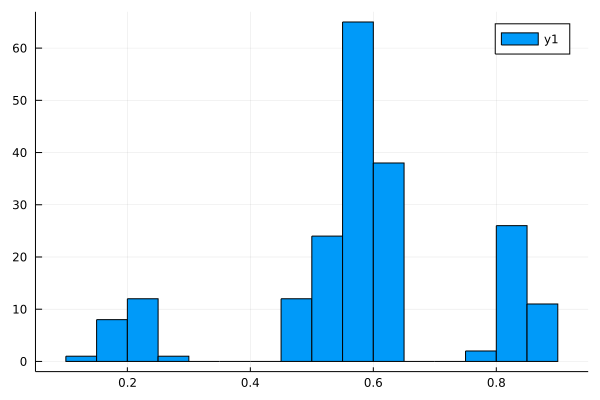

In [37]:
histogram(map(x->x.params[1], real_p), bins=20)

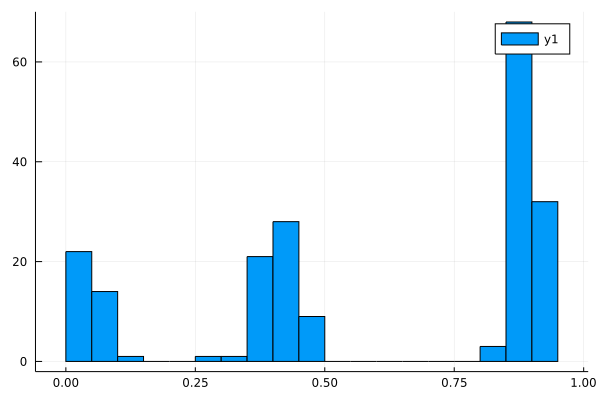

In [38]:
histogram(map(x->x.params[2], real_p), bins=20)

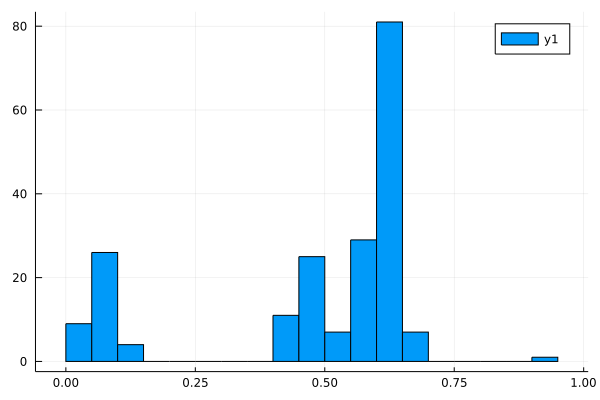

In [40]:
histogram(map(x->x.params[3], real_p), bins=20)

In [1]:
plotly()
scatter(map(x->1.0-x.params[1], real_p), map(x->x.params[2], real_p), map(x->x.params[3], real_p), 
    xlabel="p_keep", ylabel="p_info", zlabel="p_transfer")

LoadError: UndefVarError: plotly not defined

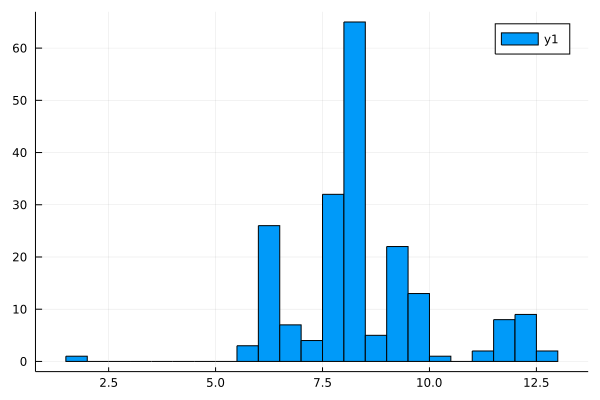

In [39]:
histogram(map(x->x.params[4], real_p), bins=20)

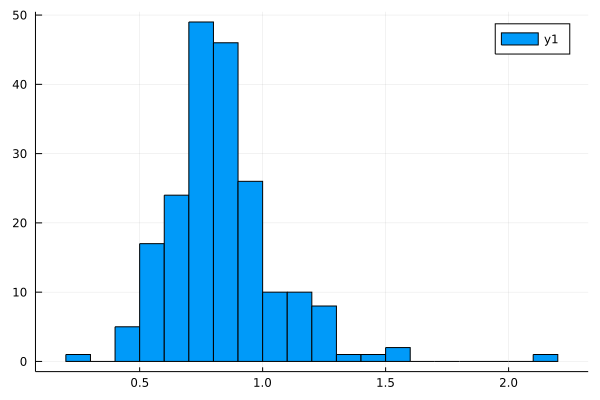

In [28]:
histogram(map(x->x.dist, abc_result[200:end]))